In [53]:
## 📌 Importar Librerías
import numpy as np
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from alpha_vantage.timeseries import TimeSeries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import plotly.graph_objects as go

In [54]:
## 📌 API Key de Alpha Vantage
ALPHA_VANTAGE_API_KEY = "6XE23J2QP58EE8L7"

## 📌 Función para Descargar Datos
def obtener_datos_alpha_vantage(ticker, api_key, intentos=5):
    ts = TimeSeries(key=api_key, output_format='pandas')
    for i in range(intentos):
        try:
            print(f"Descargando datos para {ticker} (Intento {i+1}/{intentos})...")
            data, _ = ts.get_daily(symbol=ticker, outputsize='full')
            data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
            data.index = pd.to_datetime(data.index)
            return data.sort_index()
        except Exception as e:
            print(f"Error: {e}")
            time.sleep(5)
    raise Exception("No se pudieron descargar los datos.")

In [55]:
## 📌 Configuración del Ticker
ticker = 'RDDT'
start_date = datetime.datetime(2022, 1, 1)

## 📌 Descargar Datos
data = obtener_datos_alpha_vantage(ticker, ALPHA_VANTAGE_API_KEY)
data = data.loc[data.index >= start_date]
print(f"Última fecha disponible en los datos: {data.index.max()}")


Descargando datos para RDDT (Intento 1/5)...
Última fecha disponible en los datos: 2025-03-06 00:00:00


In [56]:
## 📌 Calcular Indicadores Técnicos
data['RSI'] = data['Close'].diff().rolling(14).mean()
data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()
data['MACD_Histogram'] = data['MACD'] - data['Signal_Line']
data['%K'] = 100 * (data['Close'] - data['Low'].rolling(14).min()) / (data['High'].rolling(14).max() - data['Low'].rolling(14).min())
data['%D'] = data['%K'].rolling(3).mean()

## 📌 Índice de Capital Institucional (ICI)
data['Volume_MA_50'] = data['Volume'].rolling(window=50).mean()
data['Institutional_Index'] = data['Volume'] / data['Volume_MA_50']

## 📌 Definir Entrada y Salida de Capital
entrada_umbral = 2.0
salida_umbral = 0.5
data['Entrada_Capital'] = (data['Institutional_Index'] > entrada_umbral).astype(int)
data['Salida_Capital'] = (data['Institutional_Index'] < salida_umbral).astype(int)


In [57]:
## 📌 Preprocesamiento de Datos
data.fillna(method='ffill', inplace=True)
data.dropna(inplace=True)
features = ['RSI', 'MACD', 'Signal_Line', '%K', '%D', 'Volume', 'Institutional_Index']
X = data[features].values
y = data['Entrada_Capital'].values  

## 📌 Normalización de Datos
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

## 📌 División de Datos en Train/Test
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

# 📌 Aplicar SMOTE para balancear clases
if np.sum(y_train == 1) > 1:
    print("Aplicando SMOTE para balancear las clases...")
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

Aplicando SMOTE para balancear las clases...


C:\Users\Daniel Bolaños\AppData\Local\Temp\ipykernel_7324\3991815846.py:2: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [58]:
## 📌 Entrenar Modelo LSTM
model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(1, X_train.shape[1])),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

X_train_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

model_lstm.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, verbose=1,
               validation_data=(X_test_reshaped, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

## 📌 Generar Características para XGBoost
X_train_lstm_features = model_lstm.predict(X_train_reshaped).flatten()
X_test_lstm_features = model_lstm.predict(X_test_reshaped).flatten()

## 📌 Entrenar Modelo XGBoost
model_xgb = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, scale_pos_weight=10)
model_xgb.fit(X_train_lstm_features.reshape(-1, 1), y_train)
y_pred = model_xgb.predict(X_test_lstm_features.reshape(-1, 1))

## 📌 Evaluación del Modelo
print(f"Precisión XGBoost: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-Score: {f1_score(y_test, y_pred)}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred)}")

Epoch 1/50


C:\Users\Daniel Bolaños\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6524 - loss: 0.6914 - val_accuracy: 0.7419 - val_loss: 0.6912
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7668 - loss: 0.6878 - val_accuracy: 0.0968 - val_loss: 0.6973
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5425 - loss: 0.6827 - val_accuracy: 0.0645 - val_loss: 0.7060
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5051 - loss: 0.6754 - val_accuracy: 0.0645 - val_loss: 0.7159
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5128 - loss: 0.6596 - val_accuracy: 0.0968 - val_loss: 0.7245
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5140 - loss: 0.6522 - val_accuracy: 0.1613 - val_loss: 0.7101
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6376 - loss: 0.6134 - val_accuracy: 0.1935 - val_loss: 0.7006
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7310 - loss: 0.5693 - val_accuracy: 0.8710 - val_loss: 0.6035

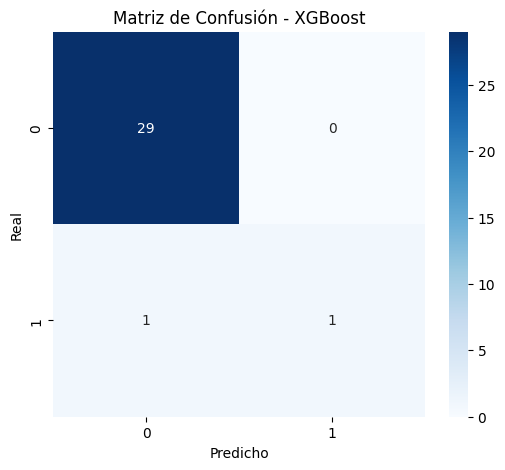

In [59]:
# 📌 📊 Matriz de Confusión
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión - XGBoost')
plt.show()

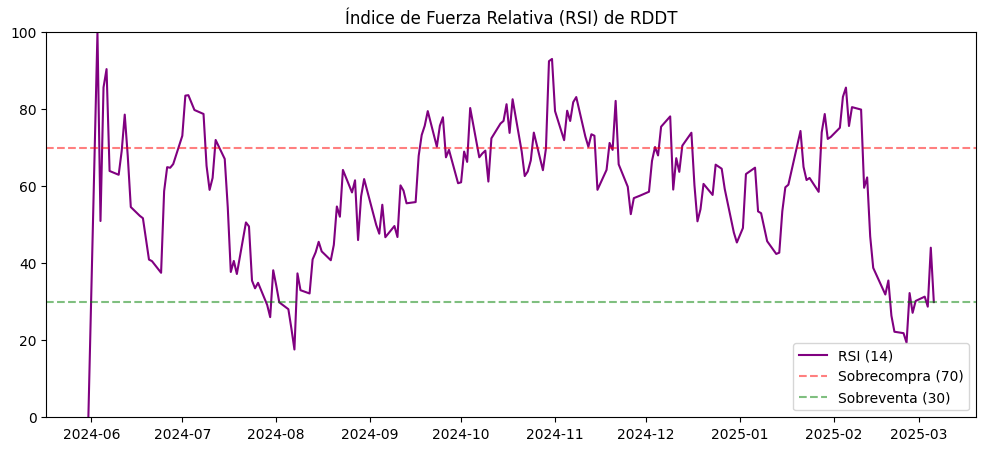

In [60]:
# 📌 📊 Cálculo CORRECTO del RSI con Media Móvil Exponencial
window_rsi = 14  # Ventana estándar

delta = data['Close'].diff(1)  # Diferencia de precio día a día

# 📌 Separar ganancias y pérdidas
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)

# 📌 Media móvil exponencial de ganancias y pérdidas
avg_gain = pd.Series(gain, index=data.index).ewm(span=window_rsi, adjust=False).mean()
avg_loss = pd.Series(loss, index=data.index).ewm(span=window_rsi, adjust=False).mean()

# 📌 Evitar división por cero en `rs`
rs = avg_gain / (avg_loss + 1e-10)  # Se suma un pequeño valor para evitar errores

# 📌 Calcular el RSI
data['RSI'] = 100 - (100 / (1 + rs))

# 📌 📊 Gráfico del RSI
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['RSI'], color='purple', label="RSI (14)")
plt.axhline(70, linestyle='--', color='red', alpha=0.5, label="Sobrecompra (70)")
plt.axhline(30, linestyle='--', color='green', alpha=0.5, label="Sobreventa (30)")
plt.ylim(0, 100)  # Asegurar el rango 0-100
plt.title(f'Índice de Fuerza Relativa (RSI) de {ticker}')
plt.legend()
plt.show()

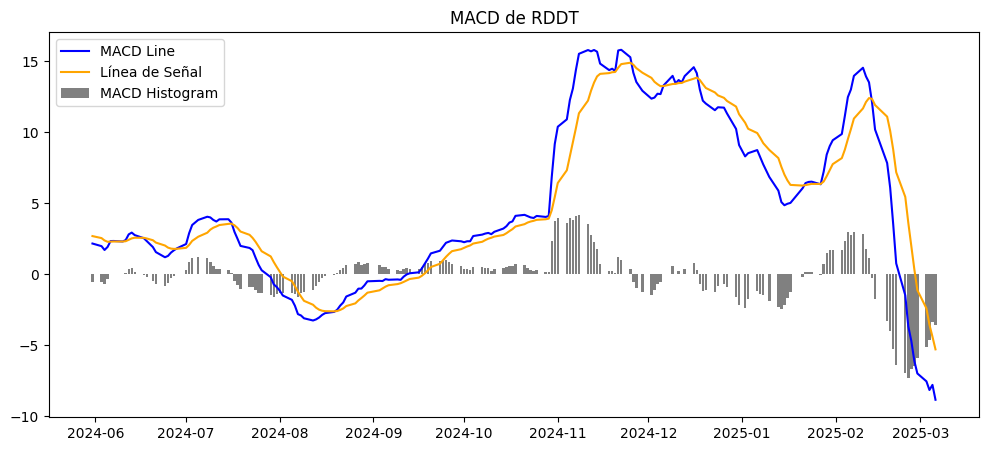

In [61]:
# 📌 📊 Gráfico MACD
plt.figure(figsize=(12, 5))
plt.bar(data.index, data['MACD_Histogram'], color='gray', label="MACD Histogram")
plt.plot(data.index, data['MACD'], color='blue', label="MACD Line")
plt.plot(data.index, data['Signal_Line'], color='orange', label="Línea de Señal")
plt.title(f'MACD de {ticker}')
plt.legend()
plt.show()

In [62]:
# 📌 📊 Gráfico de Velas Japonesas con Señales Institucionales
fig = go.Figure()
fig.add_trace(go.Candlestick(
    x=data.index, 
    open=data['Open'], 
    high=data['High'], 
    low=data['Low'], 
    close=data['Close'], 
    name='Precio'
))
fig.add_trace(go.Scatter(
    x=data.index[data['Entrada_Capital'] == 1], 
    y=data['Close'][data['Entrada_Capital'] == 1], 
    mode='markers', 
    marker=dict(size=10, color='green', symbol='triangle-up'), 
    name='Entrada de Capital'
))
fig.add_trace(go.Scatter(
    x=data.index[data['Salida_Capital'] == 1], 
    y=data['Close'][data['Salida_Capital'] == 1], 
    mode='markers', 
    marker=dict(size=10, color='blue', symbol='triangle-down'), 
    name='Salida de Capital'
))
fig.update_layout(
    title=f'Señales Institucionales para {ticker}',
    xaxis_title='Fecha',
    yaxis_title='Precio',
    xaxis_rangeslider_visible=False,
    template='plotly_dark',
    height=600,
    width=1000
)
fig.show()

# 📌 Definir Señal de Compra Tradicional (Condiciones)
buy_signal = (data['RSI'] < 30) & (data['%K'] < 20) & (data['MACD'] < -5)
data['Señal_Compra'] = 0
data.loc[buy_signal, 'Señal_Compra'] = 1  # Marcar las señales de compra

# 📌 Extraer fechas y precios de las señales de compra
buy_dates = data.index[data['Señal_Compra'] == 1]
buy_prices = data['Close'][data['Señal_Compra'] == 1]

# 📌 Agregar Señales de Compra al Gráfico de Velas Japonesas
fig.add_trace(go.Scatter(
    x=buy_dates, 
    y=buy_prices, 
    mode='markers', 
    marker=dict(size=10, color='yellow', symbol='triangle-up'), 
    name='Señal de Compra'
))

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
import yfinance as yf

# 📌 Función para obtener datos fundamentales desde Yahoo Finance
def obtener_valuacion_yahoo(ticker):
    try:
        print(f"📊 Descargando datos fundamentales para {ticker} desde Yahoo Finance...")

        # 📌 Descargar los datos del ticker
        stock = yf.Ticker(ticker)
        info = stock.info  # Información de la empresa

        # 📌 Extraer las métricas fundamentales
        pe_ratio = info.get("trailingPE", None)
        pb_ratio = info.get("priceToBook", None)
        ev_to_ebitda = info.get("enterpriseToEbitda", None)

        # 📌 Crear índice de valoración (solo con métricas disponibles)
        valid_metrics = [m for m in [pe_ratio, pb_ratio, ev_to_ebitda] if m is not None]
        valuation_index = sum(valid_metrics) / len(valid_metrics) if valid_metrics else None

        return pe_ratio, pb_ratio, ev_to_ebitda, valuation_index

    except Exception as e:
        print(f"❌ Error obteniendo datos fundamentales: {e}")
        return None, None, None, None

# 📌 Obtener métricas de valoración para NFLX
pe_ratio, pb_ratio, ev_to_ebitda, valuation_index = obtener_valuacion_yahoo(ticker)

# 📌 Evaluación de valoración
if valuation_index is not None:
    print(f"📊 P/E Ratio: {pe_ratio if pe_ratio else 'N/A'} | P/B Ratio: {pb_ratio if pb_ratio else 'N/A'} | EV/EBITDA: {ev_to_ebitda if ev_to_ebitda else 'N/A'}")
    print(f"📊 Índice de Valoración: {valuation_index:.2f}")
    
    if valuation_index > 2.5:
        print("⚠️ La empresa está MUY SOBREVALORADA 📈 (Riesgo de caída)")
    elif valuation_index < 1:
        print("✅ La empresa está INFRAVALORADA 📉 (Oportunidad de compra)")
    else:
        print("🔍 La empresa tiene una valoración razonable.")
else:
    print("❌ No se pudo calcular el índice de valoración debido a la falta de datos.")


📊 Descargando datos fundamentales para RDDT desde Yahoo Finance...
📊 P/E Ratio: N/A | P/B Ratio: 14.260811 | EV/EBITDA: -52.616
📊 Índice de Valoración: -19.18
✅ La empresa está INFRAVALORADA 📉 (Oportunidad de compra)


In [ ]:
# 📌 Agregar índice de valoración como una nueva característica en `data`
data['Valoración'] = valuation_index  

# 📌 Añadir la variable de valoración a nuestro conjunto de entrenamiento
features = ['RSI', 'MACD', 'Signal_Line', '%K', '%D', 'Volume', 'Institutional_Index', 'Valoración']
X = data[features].values


In [ ]:
# 📌 Nueva condición: NO comprar si la empresa está sobrevalorada
buy_signal = (data['RSI'] < 30) & (data['%K'] < 20) & (data['MACD'] < -5) & (data['Valoración'] < 2.5)

data['Señal_Compra'] = 0
data.loc[buy_signal, 'Señal_Compra'] = 1


C:\Users\Daniel Bolaños\AppData\Local\Temp\ipykernel_23192\1900449925.py:13: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



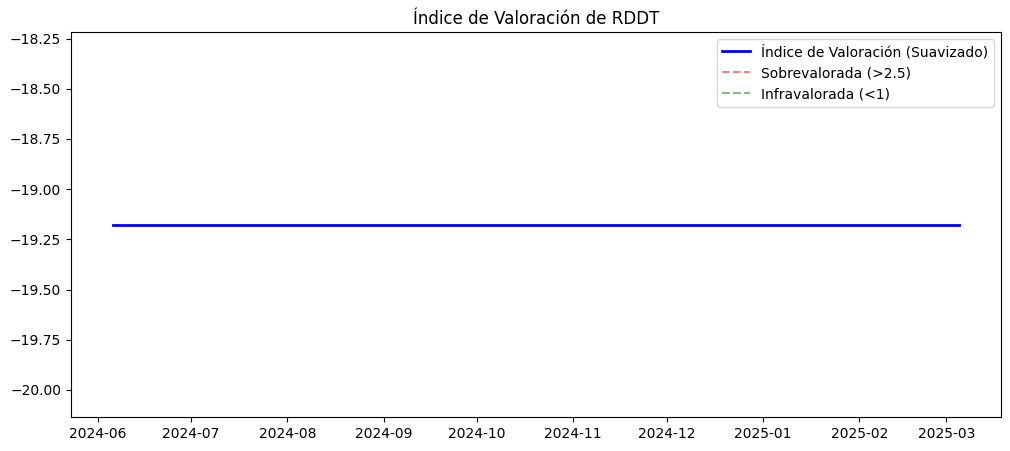

In [ ]:
# 📌 📊 Gráfico del Índice de Valoración con autoajuste y suavizado
plt.figure(figsize=(12, 5))

# Suavizar la línea con una media móvil (opcional)
data['Valoración_Suave'] = data['Valoración'].rolling(window=5).mean()

plt.plot(data.index, data['Valoración_Suave'], color='blue', linewidth=2, label="Índice de Valoración (Suavizado)")

# 📌 Ajustar el rango dinámicamente
min_valor = data['Valoración'].min()
max_valor = data['Valoración'].max()
margen = (max_valor - min_valor) * 0.1  # 10% de margen
plt.ylim(min_valor - margen, max_valor + margen)

# 📌 Líneas de referencia de sobrevaloración e infravaloración
plt.axhline(2.5, linestyle='--', color='red', alpha=0.5, label="Sobrevalorada (>2.5)")
plt.axhline(1, linestyle='--', color='green', alpha=0.5, label="Infravalorada (<1)")

# 📌 Etiquetas y título dinámico
plt.title(f'Índice de Valoración de {ticker}')
plt.legend()
plt.show()
